# AOS_PS1_catalogs

Notebook to illustrate the stellar densities at which we are probing PS1 catalog. 

The fields were chosen based on their galactic latitude: 
    * high (l,b) = (+85, 0)
    * med (l,b) = (+40, 0)
    * low (l,b) = (+10, 0)
    
One field was added to test the highest density - Baade's window 

* Baade (l,b) = (-3.92, 1.02)

We illustrate the location of these fields using as a background GALFAST simulation

In [31]:
from astropy.table import Table
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u

gt = Table(data=[['high','med','low','Baade'],
                            [0,0,0,1.02],
                           [85,40,10,-3.92 ]], 
                      names=['name', 'l_deg','b_deg'])

gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')

gt['ra_deg'] = gaia_coords.icrs.ra.deg
gt['dec_deg'] = gaia_coords.icrs.dec.deg

# rewrite as dict for easier access of coordinates 
# of a specific field by name 
gt_dict = {}
for i in range(len(gt)):
    gt_dict[gt['name'][i]]  = {'ra':gt['ra_deg'][i], 
                               'dec':gt['dec_deg'][i]}
gt_dict

{'high': {'ra': 197.46441300863182, 'dec': 24.33554243027582},
 'med': {'ra': 233.01733592061046, 'dec': -4.447088188407341},
 'low': {'ra': 257.11044958320826, 'dec': -23.409732178640596},
 'Baade': {'ra': 270.88380338652223, 'dec': -30.035274475954893}}

In [32]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Column
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.table import hstack
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import numpy as np
from astropy.io import fits

I take the code below from https://github.com/suberlak/crowded_fields/blob/master/code/N0_DECAPS_select_MAF.ipynb

As well as https://github.com/lsst-ts/ts_phosim/blob/uw_dev/notebooks/analysis_notebooks/AOS_GAIA_catalog.ipynb



I copied the relevant file to LSP from the laptop:
    
    scp ~/Desktop/starDensity_r_nside_64.npz scichris@lsst-login01.ncsa.illinois.edu:/project/scichris/aos/
    
On LSP:
    
    cp /project/scichris/aos/starDensity_r_nside_64.npz /home/scichris/notebooks/
    
So that I can load it below:   

In [9]:
def make_healpix_table(r_max=24.5):
    ''' A convenience function 
    to read in the MAF simulation data,
    and given the limiting r magnitude, 
    return stellar density per healpixel,
    and the fraction of healpixels with higher
    density , together with ra,dec coord 
    of each healpixel. We use the constraint 
    r < r_max, with  65 magnitude bins between 
    15 and 28 mag every 0.2 mag. 
    
    '''
    # the data consists of 
    # data['starDensity'],  expressed as stars / sq. deg  ,  per pixel, per magnitude
    # data['bins'], defining the magnitude ranges for each of the 65 magnitude bins 
    # data['overMaxMask'], which tells where there are more than 1e6 stars 
    data = np.load('starDensity_r_nside_64.npz')


    # Cumulative number counts, units of stars/sq deg. Array at healpix locations
    # magnitude bins 
    mag_bins = data['bins'].copy()
    # pixels where there were so many  (1e6 ) stars some were skipped
    mask = data['overMaxMask'].copy()
    # in this simulation none were skipped : 
    # np.sum(mask) = 0

    # select only bins up to r_max - then selecting the final bin will 
    # give us the source count up to depth of r_max mag 
    bright_mag_idx, = np.where(mag_bins<r_max)
    print('Selecting only the source density up \
    to the depth of ', r_max, ' mag')
    faintest_mag_idx = bright_mag_idx[-1]

    # Since the data is already cumulative, just choose the  last bin: 
    # this will have the number of stars up to the faintest magnitude 
    # bin in a given  healpixel 
    starDensity_lt_245 = data['starDensity'][:,faintest_mag_idx]
    # len(starDensity_lt_245) = len(data['starDensity]) = 49142

    # Generate the ra, dec array from healpy
    nside = hp.npix2nside(np.size(mask))
    lat,ra = hp.pix2ang(nside, np.arange(np.size(mask)))
    dec = np.pi/2-lat

    # only select those healpixels for which we have any simulation data ...
    m = starDensity_lt_245 > 0

    density = starDensity_lt_245[m]
    ra = ra[m]
    dec = dec[m]

    # For each pixel calculate how many pixels have a higher or equal density 
    N_px_greater  = np.zeros_like(density)
    for i in range(len(density)):
        N_px_greater[i]=np.sum(density>=density[i])

    # calculate the fraction of pixels that have a higher density (by area)
    frac_greater  = N_px_greater /  len(density)

    # Make an AstroPy table with healpix data...

    healpix_table = Table([density, ra,dec, N_px_greater, frac_greater], 
                          names=('source_density','ra_rad','dec_rad', 'N_px_greater', 
                                 'frac_greater'))
    return healpix_table , nside


In [23]:
healpix_table

source_density,ra_rad,dec_rad,N_px_greater,frac_greater,ra_deg,dec_deg
float64,float64,float64,float64,float64,float64,float64
10476.0,0.0,0.6100600350363932,24429.0,0.6298731435643564,0.0,34.95386525718846
11916.0,0.02454369260617026,0.6100600350363932,22679.0,0.5847514438943895,1.40625,34.95386525718846
11160.0,0.04908738521234052,0.6100600350363932,23582.0,0.6080342409240924,2.8125,34.95386525718846
9756.0,0.07363107781851078,0.6100600350363932,25488.0,0.6571782178217822,4.21875,34.95386525718846
10044.0,0.09817477042468103,0.6100600350363932,25058.0,0.6460911716171617,5.625,34.95386525718846
9756.0,0.12271846303085128,0.6100600350363932,25488.0,0.6571782178217822,7.031249999999999,34.95386525718846
10908.0,0.14726215563702155,0.6100600350363932,23901.0,0.6162592821782178,8.4375,34.95386525718846
9684.0,0.1718058482431918,0.6100600350363932,25606.0,0.6602207095709571,9.84375,34.95386525718846
9288.0,0.19634954084936207,0.6100600350363932,26169.0,0.674737004950495,11.25,34.95386525718846


In [10]:


healpix_table, nside = make_healpix_table()
healpix_coords = SkyCoord(healpix_table['ra_rad'],
                          healpix_table['dec_rad'], 
                          frame='icrs', unit='rad')

Selecting only the source density up     to the depth of  24.5  mag


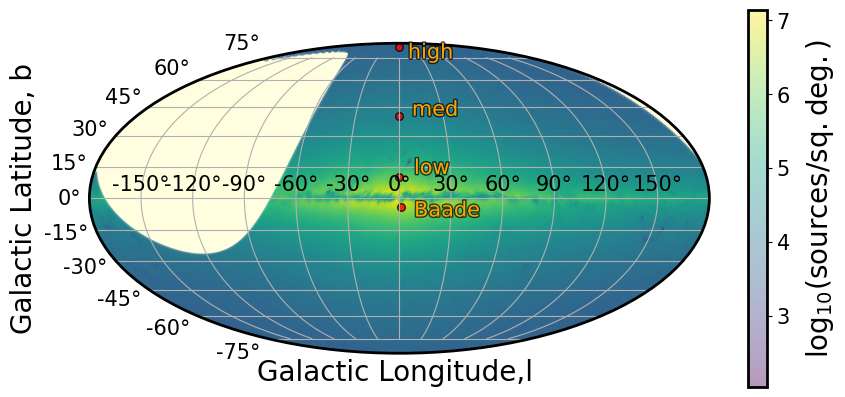

In [12]:
# Define the tick formatter to have degrees ....
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
import matplotlib
rcParams = matplotlib.rcParams
#from astroML.plotting import setup_text_plots
#setup_text_plots( usetex=True)

def degrees( x, pos=None):
    """
    Used to format the theta tick labels.  Converts the native
    unit of radians into degrees and adds a degree symbol.
    """
    degrees = (x / np.pi) * 180.0
    degrees = np.round(degrees)
    if rcParams['text.usetex'] and not rcParams['text.latex.unicode']:
        return r"$%0.0f^\circ$" % degrees
    else:
        return "%0.0f\u00b0" % degrees
    
# plotting  in mollweide projection ...  
# express the MAF healpixel coords in galactic 
# coords,  in degrees 
healpix_longitude = healpix_coords.galactic.l.deg
healpix_latitude  = healpix_coords.galactic.b.deg

# shift the scale : healpix is 0, 360, and we want to go -180,180 
ind = healpix_longitude > 180
healpix_longitude[ind] -=360    # scale conversion to [-180, 180]
healpix_longitude = - healpix_longitude   # reverse the scale: East to the left

# color by the log of counts per sq deg 
z =  np.log10(healpix_table['source_density'].data)

# Plot in Mollweide projection the MAF densities 
# in Galactic coordinates 
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(111, projection='mollweide', facecolor ='LightYellow')

# convert degrees to radians
imge = ax.scatter(np.radians(healpix_longitude),
                  np.radians(healpix_latitude),  
                  alpha=0.4, s=14, c=z,
                  zorder=-5) # make sure that the background is underneath everything else with zorder  

# plot the four GAIA fields 

gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')
gaia_longitude = gaia_coords.galactic.l.rad
gaia_latitude = gaia_coords.galactic.b.rad

# switch the range of coords from (0,2pi) to (-pi,pi) for longitude
ind = gaia_longitude>np.pi
gaia_longitude[ind] -= 2*np.pi
#gaia_longituge =- gaia_longitude

# this only plots the gaia coords as same-size markers. 
ax.scatter(gaia_longitude, gaia_latitude, alpha=0.8, s=30,c='red',
          edgecolors='black')

#ax.scatter(np.pi, 0, s=40,c='orange')
# chosen by hand for no overlap with other plot elements
# these are in radians 
xtext = {'high':0.2, 'med':0.15, 'low':0.15, 'Baade':0.15, 'LMC':-1.3, 'SMC':-0.8}
ytext={'high':1.3, 'med':0.7, 'low':0.2, 'Baade':-0.15, 'LMC':-0.6, 'SMC':-0.8}

# annotate each field 
i = 0 
for key in gt_dict.keys():
    xc = gaia_longitude[i]
    yc = gaia_latitude[i]
    name = key
    txt = ax.annotate(name, xy=(xc,yc),xytext=(xtext[name],ytext[name]),
               color='orange')
    # from
    # https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black',alpha=0.7)])
    i += 1 
    #plt.draw()

# Also, plot the SMC,LMC fields 
#ax.scatter(lmc_coord.galactic.l.rad, lmc_coord.galactic.b.rad)


# set the tick labels with degree formatting 
origin = 0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+origin,360)
ax.set_xticklabels(tick_labels)  
ax.xaxis.set_major_formatter(FuncFormatter(degrees))
ax.set_xlabel('Galactic Longitude,l ')
ax.set_ylabel('Galactic Latitude, b')
ax.grid(True)
cbar = plt.colorbar(imge)
cbar.set_label(r'$\log_{10}{(\mathrm{sources / sq.deg.})}$', labelpad=10)
plt.savefig('MAF_DECAPS.png',  bbox_inches='tight')

What density percentage do these  locations correspond to ? 

In [15]:
# add ra and dec in degrees so that we can simply crossmatch the two catalogs...
healpix_coords = SkyCoord(healpix_table['ra_rad'],
                          healpix_table['dec_rad'], 
                          frame='icrs', unit='rad')

#healpix_table['ra_deg'] = np.rad2deg(healpix_table['ra_rad'])
#healpix_table['dec_deg'] = np.rad2deg(healpix_table['dec_rad'])

In [20]:
idx, d2d, d3d = gaia_coords.match_to_catalog_sky(healpix_coords)

In [21]:
gaia_healpix = hstack([gt, healpix_table[idx]])
gaia_healpix['d2d_deg'] = d2d.degree

In [27]:
gaia_healpix['percent_below_given_density'] = 100*(1-gaia_healpix['frac_greater'])

In [28]:
gaia_healpix[['name','source_density','N_px_greater', 'frac_greater',
             'percent_below_given_density']]

name,source_density,N_px_greater,frac_greater,percent_below_given_density
str5,float64,float64,float64,float64
high,4716.0,37549.0,0.9681569719471947,3.1843028052805256
med,22644.0,15983.0,0.4121029290429043,58.789707095709566
low,640476.0,1483.0,0.03823741749174917,96.17625825082509
Baade,6111216.0,21.0,0.000541460396039604,99.94585396039604


What's the input catalog size - what's the density per sq. deg. ?  

For comCam, the query half-radius was 0.4 degrees (in `run_ps1_1_catalogs.py`), and it was a square, so the total size was 0.16 sq.deg.. Show :

In [51]:
import pandas as pd
import numpy as np
import run_ps1_functions as func
import imp
import os
imp.reload(func)
field = 'high'
instr = 'comCam'
position = 'focal'
for field in ['high','med','low','Baade']:
    obshistid = func.calculate_obshistid(instr, field, position ,'qckBkgndPert05_NCSA.cmd',1)
    inst_file = os.path.join('/project/scichris/aos/AOS/DM-28360/',
                             f'stars_{instr}_PS1_{field}_{position}_{obshistid}.inst'
                            )
    cat = np.genfromtxt(inst_file,skip_header=16)
    cat_df = pd.DataFrame(cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])
    N_src_area = len(cat_df)
    area_sq_deg = dec_range * ra_range
    N_src_per_sq_deg = N_src_area / area_sq_deg

    print(field, area_sq_deg, N_src_area, N_src_per_sq_deg)


high 0.7015514645696351 5541 7898.208869678737
med 0.7015514645696351 9831 14013.227106625458
low 0.7015514645696351 281084 400660.55620371376
Baade 0.7015514645696351 412463 587929.7825328101


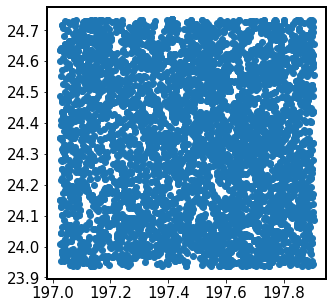

In [45]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(cat_df['ra'], cat_df['dec'])
ra_range = max(cat_df['ra']) - min(cat_df['ra'])
dec_range=max(cat_df['dec']) - min(cat_df['dec'])

In [49]:
area_sq_deg

0.7015514645696351